In [2]:
import parent
import data
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.decomposition import PCA

In [3]:
triangles = data.get_dataset_triangles("train", data_size=64, samples=2)
triangles = torch.cat([tensors[0] for tensors in triangles[0]])

In [4]:
t_flat = np.array(torch.reshape(triangles, (6000, 64 * 64)))
tpca = PCA(n_components=16)
tpca.fit(t_flat)

t_transformed = tpca.transform(t_flat)

t_transformed = t_transformed / np.sqrt(np.mean(t_transformed**2, axis=0, keepdims=True))
#p.load_state_dict({'registration_network.image_embedding.weight':torch.tensor(t_transformed).float()}, strict=False)

#print(np.mean(t_transformed, axis=0))
#print(t_transformed.shape)
embed_params = next(p.registration_network.image_embedding.parameters())
doop = np.array(embed_params.detach().cpu())

np.mean(doop, axis=0)

plt.scatter(doop[:, 0], doop[:, 1])
plt.scatter(t_transformed[:, 0], t_transformed[:, 1])
plt.show()



RuntimeError: shape '[6000, 4096]' is invalid for input of size 8192

In [4]:
def sample_from_image(image, index, position):

    image_shape = image.shape[2:]

    assert(position.shape[0] == index.shape[0])
    assert(position.shape[1] == len(image.shape) - 2)
    
    # only implemented for dimension 2
    assert(position.shape[1] == 2)
    
    # http://supercomputingblog.com/graphics/coding-bilinear-interpolation/2/
    
    #Wrong, fix corner positions
    xPrime = .5 + position[:, 0] * (image_shape[0] - 1)
    yPrime = .5 + position[:, 1] * (image_shape[1] - 1)
    
    q12x = torch.floor(xPrime)
    q12y = torch.floor(yPrime)
    
    q12x = torch.clamp(q12x, 0, image_shape[0] - 1)
    q12y = torch.clamp(q12y, 0, image_shape[1] - 1)
    
    q22x = torch.ceil(xPrime)
    q22y = q12y
    
    q22x = torch.clamp(q22x, 0, image_shape[0] - 1)
    
    q11x = q12x
    q11y = torch.ceil(yPrime)
    
    q11y = torch.clamp(q11y, 0, image_shape[1] - 1)
    
    q21x = q22x
    
    q21y = q11y

    q11 = image[index, 0, q11x.long(), q11y.long()]
    q12 = image[index, 0, q12x.long(), q12y.long()]
    q21 = image[index, 0, q21x.long(), q21y.long()]
    q22 = image[index, 0, q22x.long(), q22y.long()]
    
    factor = (q21x - xPrime)
    
    

    R1 = factor * q11 + (1 - factor) * q21
    R2 = factor * q12 + (1 - factor) * q22
    
    factor = (yPrime - q12y)
    
    res = factor * R1 + (1 - factor) * R2
    

    
    return res

    
    

class RegistrationNetwork(torch.nn.Module):
    def __init__(self, num_images, dimension):
        super(RegistrationNetwork, self).__init__()
        
        ## Neural network components
        self.image_embedding_dim = 16
        self.position_embedding_dim = 1 * dimension
        self.image_embedding = torch.nn.Embedding(num_images, self.image_embedding_dim)
        
        self.layer1 = nn.Linear(2 * self.image_embedding_dim + self.position_embedding_dim, 16 * 128)
        self.layer2 = nn.Linear(16 * 128, 16 * 128)
        self.layer2a = nn.Linear(16 * 128, 16 * 128)
        #self.layer2b = nn.Linear(512, 512)
        #self.layer2c = nn.Linear(512, 512)
        #self.layer2d = nn.Linear(512, 512)
        self.layer3 = nn.Linear(16 * 128, dimension)
        
        torch.nn.init.zeros_(self.layer3.weight)
        torch.nn.init.zeros_(self.layer3.bias)
    
    def embed_position(self, position):
        return position
        out = []
        for l in range(1, 9):
            out.append(torch.sin(position * np.pi * l))
            out.append(torch.cos(position * np.pi * l))
        ret = torch.cat(out, 1)
        return ret / 20
    
    def forward(self, image_A_index, image_B_index, position):
        image_A_embedding = self.image_embedding(image_A_index)[:, 0]
        image_B_embedding = self.image_embedding(image_B_index)[:, 0]
        position_embedding = self.embed_position(torch.clip(position, 0, 1))
        
        x = torch.cat([image_A_embedding, image_B_embedding, position_embedding], axis=1)
        x = torch.sin(self.layer1(x))
        x = torch.sin(self.layer2(x))
        x = torch.sin(self.layer2a(x))
        #x = F.relu(self.layer2b(x))
        #x = F.relu(self.layer2c(x))
        #x = F.relu(self.layer2d(x))

        x = self.layer3(x)
        
        x = position + x
        
        return x
class TrainingProcedure(torch.nn.Module):
    def __init__(self, image_tensor, batch_size, dimension):
        super(TrainingProcedure, self).__init__()
        self.image_tensor = image_tensor.cuda()
        self.num_images = image_tensor.shape[0]
        self.registration_network = RegistrationNetwork(self.num_images, dimension)
        self.batch_size = batch_size
        self.dimension = dimension
    
    def forward(self):
        device = next(self.registration_network.parameters()).device
        image_A_index = torch.randint(0, self.num_images, size=[self.batch_size, 1], device=device)
        image_B_index = torch.randint(0, self.num_images, size=[self.batch_size, 1], device=device)
        image_A_position = torch.rand((self.batch_size, self.dimension), device=device)
        
        image_B_position = self.registration_network(image_A_index, image_B_index, image_A_position)
        
        image_A_intensity = sample_from_image(self.image_tensor, image_A_index, image_A_position)
        image_B_intensity = sample_from_image(self.image_tensor, image_B_index, image_B_position)
        
        #fx_noise = torch.randn(tuple(image_B_position.shape), device=image_B_position.device) * .01
        
        approx_image_A_position = self.registration_network(image_B_index, image_A_index, image_B_position)
        
        return (
            torch.mean((image_A_intensity - image_B_intensity)**2),
            torch.mean((image_A_position - approx_image_A_position)**2)
        )
        
        
        
        
        

p = TrainingProcedure(triangles, 2048, 2)
        

In [21]:
p.cuda()
optimizer = torch.optim.Adam(p.parameters(), lr=.001)
p.train()

TrainingProcedure(
  (registration_network): RegistrationNetwork(
    (image_embedding): Embedding(2, 16)
    (layer1): Linear(in_features=34, out_features=2048, bias=True)
    (layer2): Linear(in_features=2048, out_features=2048, bias=True)
    (layer2a): Linear(in_features=2048, out_features=2048, bias=True)
    (layer3): Linear(in_features=2048, out_features=2, bias=True)
  )
)

In [22]:
for _ in range(1000000):
    optimizer.zero_grad()
    Lsim, Linv = p()

    loss = Lsim + 125 * Linv
    loss.backward()
    optimizer.step()

    if _ % 100 == 0:
        print(Lsim, Linv)

tensor(0.5072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4700, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.5891e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.7806e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.2462e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(3.9089e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5434, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5197, device='cuda:0', grad_fn=<MeanBackward0>) tensor(3.6382e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(3.4634e-

KeyboardInterrupt: 

In [7]:
import numpy as np

D = 64
x, y = np.mgrid[0:1:D * 1j, 0:1:D * 1j]

x = x.flatten()
y = y.flatten()

position = torch.tensor(np.concatenate([[x], [y]]).transpose())
j = 0

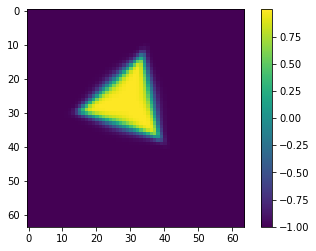

In [9]:
j += 1

image_A_index = 0
image_B_index = 1
position_in_image_A = torch.tensor(np.concatenate([[x], [y]]).transpose())
zz = sample_from_image(triangles, image_A_index *  torch.ones(D**2).long(), position).reshape(D, D)
plt.imshow(zz)
plt.colorbar()
plt.show()

In [10]:
image_A_index += 1

D = 64

p_A_grid = position_in_image_A.reshape([D, D, 2]).detach().cpu()

position_in_image_B = p.registration_network(
    image_A_index *  torch.ones((D**2, 1)).long().cuda(),
    image_B_index *  torch.ones((D**2, 1)).long().cuda(),
    position_in_image_A.float().cuda()
)

p_B_grid = position_in_image_B.reshape([D, D, 2]).detach().cpu()

approx_position_in_image_A = p.registration_network(
    image_B_index *  torch.ones((D**2, 1)).long().cuda(),
    image_A_index *  torch.ones((D**2, 1)).long().cuda(),
    position_in_image_B
)
ap_A_grid = approx_position_in_image_A.reshape([D, D, 2]).detach().cpu()


In [11]:
position_in_image_B.shape

torch.Size([4096, 2])

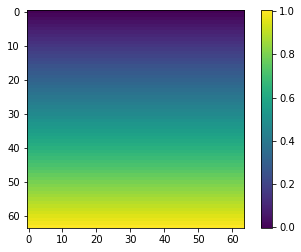

In [12]:
plt.imshow(p_B_grid[:, :, 0])
plt.colorbar()

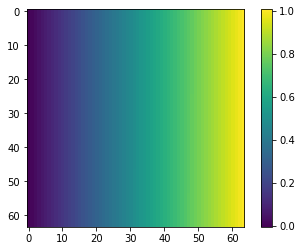

In [13]:
plt.imshow(approx_position_in_image_A.reshape([D, D, 2])[:, :, 1].detach().cpu())
plt.colorbar()

In [14]:
import visualize

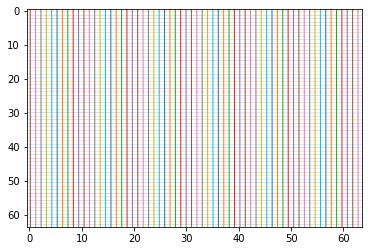

In [15]:
visualize.show_as_grid(ap_A_grid.transpose(0, 2))

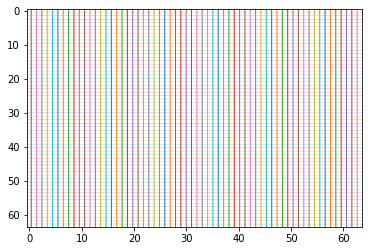

In [16]:
visualize.show_as_grid(p_B_grid.transpose(0, 2))

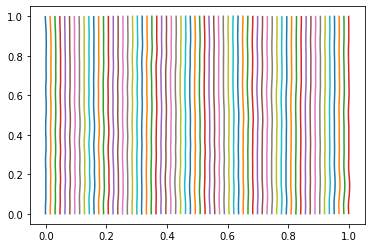

In [42]:
plt.plot(p_B_grid.transpose(0, 2)[0], p_B_grid.transpose(0, 2)[1])
plt.show()

In [167]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
